In [37]:
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import numpy as np
from scipy.spatial.distance import euclidean
import skimage

In [111]:
def calculate_starGT(instance_segmentation_map, n_rays = 8):
        """
        Calculate object prob for each pixel in the image.
        Args:
        - instance_segmentation_map: A 2D numpy array representing the instance segmentation map.
        - n_rays: The number of rays to sample for each instance.
        Returns:
        - object_probabilities: A 2D numpy array of the same shape as the input image with object probabilities.
        - star_distances: A 3D numpy array of shape (H, W, n_rays) with distances to the n_rays star points.
        - angles: A 3D numpy array of shape (H, W, n_rays) with angles to the n_rays star points.
        """

        # init the object probs with zeros
        object_probabilities = np.zeros_like(instance_segmentation_map, dtype=float)
        star_distances = np.zeros((instance_segmentation_map.shape[0],instance_segmentation_map.shape[1],n_rays), dtype=float)
        angles = np.zeros_like(star_distances, dtype=float)
        # iterate over each instance
        for inst in np.unique(instance_segmentation_map)[1:]:
            instance_pixels = (instance_segmentation_map == inst)
            boundary_pixels = skimage.segmentation.find_boundaries(instance_pixels, 2, mode='inner', background=0)
            boundary_indices = np.argwhere(boundary_pixels)
            # randomly sample n_rays points on the boundary
            n_boundary_pixels = boundary_indices.shape[0]
            try:
                ray_indices = np.random.choice(n_boundary_pixels, size=n_rays, replace=False)
            # if there are less boundary pixels than rays, sample with replacement
            except:
                ray_indices = np.random.choice(n_boundary_pixels, size=n_rays, replace=True)

            ray_points = boundary_indices[ray_indices]
            # iterate over each pixel in the instance
            for i in range(instance_segmentation_map.shape[0]):
                for j in range(instance_segmentation_map.shape[1]):
                    if instance_pixels[i,j]:
                        distances_to_background = np.linalg.norm(
                        boundary_indices - np.array([i, j]), axis=1
                        )
                        min_distance = np.min(distances_to_background)
                        # normalize to [0, 1]
                        object_probabilities[i, j] = min_distance / distances_to_background.max()
                        # calculate the distance from instace pixel to each ray point using np.linalg.norm
                        star_distances[i,j] = np.linalg.norm(ray_points - np.array([i, j]), axis=1)
                        # calc the angles with respect to the x-axis
                        angles_ray = np.arctan2(ray_points[:, 1] - j, ray_points[:, 0] - i)
                        # angles from [-pi,pi] --> [0, 2pi] and normalize to [0, 1]
                        angles[i,j] = ((angles_ray + 2 * np.pi) % (2 * np.pi)) / (2 * np.pi)               
        return object_probabilities, star_distances, angles 

In [112]:
labels_path = "/Users/ngandige/Documents/stardist/StarDist-Lizard/data/labels.npy"
instance_map = np.load(labels_path)[1,:,:,0]

In [113]:
instance_map.shape

(256, 256)

In [114]:
object_probabilities, star_distances, angles  = calculate_starGT(instance_map, n_rays = 8)

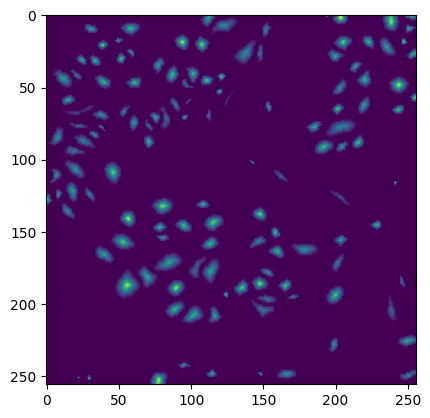

In [115]:
plt.imshow(object_probabilities)

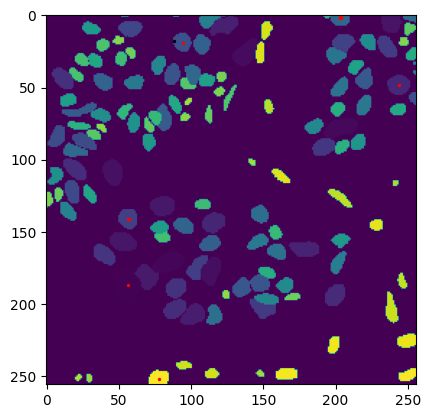

In [116]:
# select points where object_probabilities > 0.72
points = np.argwhere(object_probabilities > 0.65)
plt.imshow(instance_map)
plt.scatter(points[:,1], points[:,0], s=2, c='r')
plt.scatter(88,18,s=2, c='black')
plt.show()

In [117]:
points

array([[  1, 203],
       [  1, 204],
       [  2, 203],
       [  2, 204],
       [ 19,  94],
       [ 48, 244],
       [141,  56],
       [141,  57],
       [187,  56],
       [252,  78]])

In [118]:
print(star_distances[19,94])
print(angles[19,94])

[6.40312424 6.32455532 6.32455532 5.65685425 5.65685425 5.
 5.83095189 5.83095189]
[0.64261164 0.69879181 0.44879181 0.625      0.375      0.14758362
 0.16398957 0.66398957]


In [119]:
angles.shape

(256, 256, 8)

In [120]:
import numpy as np

def calculate_endpoint(start_point, length, angle_rad):
    x_start, y_start = start_point
    delta_x = length * np.cos(angle_rad)
    delta_y = length * np.sin(angle_rad)
    x_end = x_start + delta_x
    y_end = y_start + delta_y
    return x_end, y_end

start_point = np.array([141,  56])
length = star_distances[start_point[0], start_point[1]]
angle_rad = angles[start_point[0], start_point[1]] * 2 * np.pi
x , y = calculate_endpoint(start_point, length, angle_rad)
print(x,y)

[137. 145. 144. 135. 139. 147. 144. 148.] [51. 61. 51. 56. 50. 56. 62. 56.]


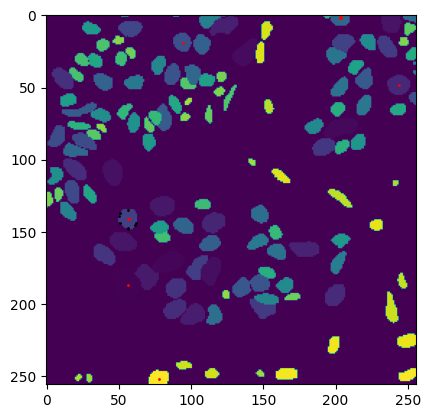

In [121]:
# select points where object_probabilities > 0.72
points = np.argwhere(object_probabilities > 0.65)
plt.imshow(instance_map)
plt.scatter(points[:,1], points[:,0], s=1, c='r')
plt.scatter(y,x,s=1, c='black')
plt.show()

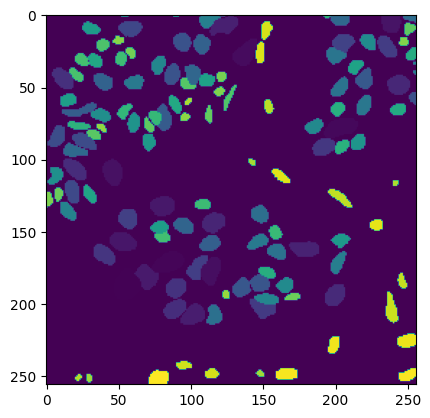

In [122]:
plt.imshow(instance_map)
